# Note: This is my first computer vision competition, so there are bound to be some mistakes, do let me know if you notice any. Will be expecting your feedback. You can reach out to me through my mail ayomideoraegbu@gmail.com

## My leaderboard score of 0.44 was possible using three ensembled models--Resnet50, Vgg16_bn and Densenet201. Each model used different data augmentation technique, this allowed for variation. Also cyclic learning and use of different image size(resizing) also improved scores. Below is my code, Enjoy!#


In [10]:
# import Libraries
import random
import os
import gc
import random
random.seed(3)
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd
!pip install -q --upgrade fastcore 
!pip install -q --upgrade fastai # Make sure we have the latest fastai
import pandas as pd
from matplotlib import pyplot as plt
from PIL import Image as PImage # TO avoid confusion later
from fastai.vision.all import *


In [2]:
# Getting Google Credentials and Authentication
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# unzipping files
!unzip "/content/gdrive/My Drive/CGIAR_Wheat_SampleSubmission.zip"
!unzip "/content/gdrive/My Drive/CGIAR_Wheat_Train_Dataset.zip"
!unzip "/content/gdrive/My Drive/Images.zip"

Streaming output truncated to the last 5000 lines.
  inflating: Images/oszw5Rh3.jpeg    
  inflating: Images/oT3qPWUS.jpeg    
  inflating: Images/ota4b1hW.jpeg    
  inflating: Images/Otd1zx5b.jpeg    
  inflating: Images/Otdn34ZV.jpeg    
  inflating: Images/ote4WhE5.jpeg    
  inflating: Images/OtigsPwy.jpeg    
  inflating: Images/OTILJQom.jpeg    
  inflating: Images/OtQsHIkT.jpeg    
  inflating: Images/OTqyX2Yg.jpeg    
  inflating: Images/oTVAnOet.jpeg    
  inflating: Images/oTwcvhZC.jpeg    
  inflating: Images/OTXnvW3j.jpeg    
  inflating: Images/oU0RQtPg.jpeg    
  inflating: Images/OU5NzDqP.jpeg    
  inflating: Images/OuAMy21S.jpeg    
  inflating: Images/ouBZdzkG.jpeg    
  inflating: Images/oUDKCa6k.jpeg    
  inflating: Images/OUHmpf1x.jpeg    
  inflating: Images/ouid0zA4.jpeg    
  inflating: Images/oUIi3Rpa.jpeg    
  inflating: Images/oUiwNJIk.jpeg    
  inflating: Images/OuLIAp6M.jpeg    
  inflating: Images/ounDmaZd.jpeg    
  inflating: Images/OuQx8rE6.jpeg    

In [5]:
# Read in the train csv
train = pd.read_csv('Train.csv')
train.head(2)

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
1,NVGUOzWu,1,1


In [7]:
# Use only high quality images 
train_hq = train[train['label_quality']== 2]
train_hq.head(2)

,UID,growth_stage,label_quality
0,nwuCTQKz,4,2
7,sYLqmiXV,3,2


In [8]:
# View the high quality dataframe to see if all growth stages are present within the high quality training csv
train_hq.growth_stage.unique()

array([4, 3, 7, 2, 5])

In [9]:
# How many images are of high quality
print("The number of images with hgh quality are:", train[train['label_quality']== 2].shape[0])

The number of images with hgh quality are: 2856


# Data Augmentation

In [ ]:
# image transformation
 
# # Image Augmentation used for Densenet201 and  lr_max = slice (10e-7, 10e-6) with 40 epochs
# tfms = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
#                        CropPad(size=256),
#                        Zoom(max_zoom=1.5, p=0.5),
#                        Warp(magnitude=0.5, p=0.5)
#                       ])


# Image Augmentation used for Resnet50 and lr_max = slice (3e-6) with 40 epochs
tfms = setup_aug_tfms([Rotate(max_deg=15, p=1.),
            RandomResizedCrop(p=1., size=256),
            Brightness(max_lighting=1.0, p=0.4),
            CropPad(size=256),
            Zoom(max_zoom=1.0, p=0.2,
            Warp(magnitude=0.2, p=0.2)
            ])


# # Image Augmentation used for Vgg16_bn and lr_max = slice (10e-6) with 40 epochs
# tfms = setup_aug_tfms([Brightness(max_lighting=0.9, p=1.,),
#                        CropPad(size=256),
#                        Zoom(max_zoom=1.1, p=0.5),
#                        Warp(magnitude=0.2, p=0.5)
#                       ])



#Creating Data Loader



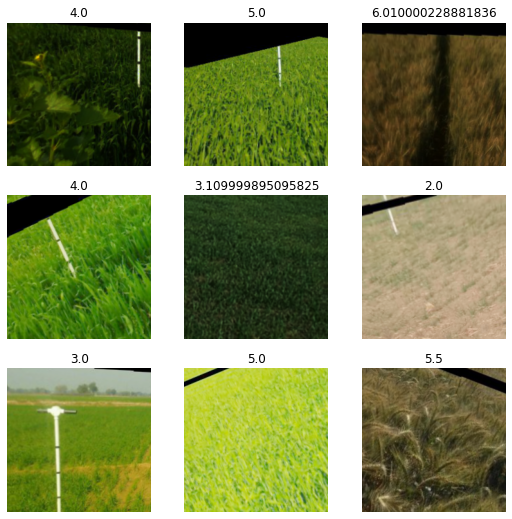

In [ ]:

# Create our dataloaders
dls = ImageDataLoaders.from_df(train_train, # train_hq if you only want the smaller high-quality set of images
                               path='Images/', 
                               suff='.jpeg', 
                               label_col='growth_stage', item_tfms=Resize(224), 
                               y_block=RegressionBlock ,
                               batch_tfms = tfms) #The only other change!
dls.show_batch()


# Define and Train Model

In [ ]:
# Training the model
learn = cnn_learner(dls, resnet50, metrics=rmse, pretrained=True).to_fp16()
learn.fine_tune(70) 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


epoch,train_loss,valid_loss,_rmse,time
0,19.473635,13.474936,3.670822,00:18


epoch,train_loss,valid_loss,_rmse,time
0,12.156361,10.248163,3.201275,00:19
1,10.662781,6.246583,2.499316,00:19
2,9.143483,5.188320,2.277788,00:19
3,7.648632,2.955851,1.719259,00:19
4,6.069869,2.658020,1.630343,00:19
5,4.848778,1.525715,1.235198,00:19
6,4.147893,1.162728,1.078299,00:19
7,3.628183,1.232059,1.109982,00:19
8,3.230879,1.035152,1.017424,00:19
9,2.853365,0.773723,0.879615,00:19


# Observe training and validation loss

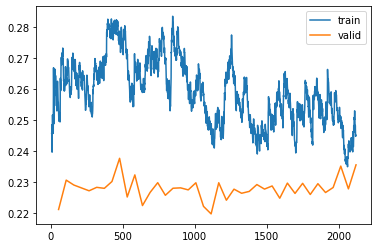

In [ ]:
learn.recorder.plot_loss()

# Unfreeze the last layer and find a good learning loss

SuggestedLRs(lr_min=3.311311274956097e-07, lr_steep=1.3182567499825382e-06)

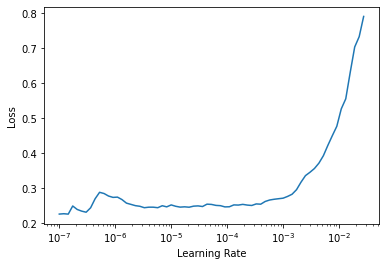

In [ ]:
learn.unfreeze()
learn.lr_find()

# Train last layer using fit_once_cycle

In [ ]:
learn.fit_one_cycle(40, lr_max=slice(10e-7, 10e-5))

epoch,train_loss,valid_loss,_rmse,time
0,0.254631,0.221152,0.470268,00:19
1,0.265119,0.230613,0.480222,00:19
2,0.265753,0.229033,0.478574,00:19
3,0.260777,0.228101,0.477599,00:19
4,0.254253,0.227176,0.476630,00:18
5,0.263871,0.228289,0.477795,00:18
6,0.270604,0.227967,0.477459,00:18
7,0.279994,0.230166,0.479756,00:18
8,0.278584,0.237639,0.487482,00:18
9,0.271049,0.225178,0.474529,00:18


# Make Predictions for the Sample Submission

In [ ]:
 # Making test dataloader and Test Time Augementation
ss = pd.read_csv('SampleSubmission.csv')
tdl = learn.dls.test_dl(ss) # Make test dataloader
preds = learn.tta(dl=tdl) # Test Time Augmentation

In [ ]:
# Making Submission
ss['growth_stage'] = preds[0].numpy() # This time our outputs are in the format we want, so this part is much easier

In [ ]:
ss.head()

,UID,growth_stage
0,F3LbWkZq,4.525391
1,6P4wLVzI,4.182007
2,Tn6HIrdS,2.621826
3,EYM5R1TK,4.109375
4,fkcevlA0,6.099609


# Read in the three Models for creating Ensembles

In [ ]:
# import the three submission 
from google.colab import drive

# Mount your Drive to the Colab VM.
drive.mount('/gdrive')
sub1 = pd.read_csv('/gdrive/My Drive/pred_densenet201_quality1_fastai_sub.csv')
sub2 = pd.read_csv('/gdrive/My Drive/pred_vgg16_quality1_fastai_sub.csv')
sub3 = pd.read_csv('/gdrive/My Drive/pred_Resnet50_fastai.csv')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Creating Ensembles and Making Submission

In [ ]:
merged_1 = pd.merge(sub1, sub2, on='UID') # Will give two columns of preds - growth_stage_x and growth_stage_y
merged = pd.merge(merged_1, sub3, on='UID')
merged['growth_stage'] = (merged['growth_stage_x'] + merged['growth_stage_y'] + merged['growth_stage'])/3
merged[['UID', 'growth_stage']].to_csv('sub_ensemble.csv', index=False)

# Import Drive API and authenticate.
from google.colab import drive

# Mount your Drive to the Colab VM.
drive.mount('/gdrive')

# Write the DataFrame to CSV file.
with open('/gdrive/My Drive/ensembled_submission.csv', 'w') as f:
  merged[['UID', 'growth_stage']].to_csv(f, index=False)


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Also using your low quality images as pseudolabels will definetly improve scores. For example using the three models to predict labels for your low quality images and ensembling these scores and using them for training. Bye for now!